In [22]:
from skimage.feature import hog
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# KNN
from sklearn.neighbors import KNeighborsClassifier

# SVM
from sklearn.svm import SVC

In [23]:
dataset_path = [os.path.join(os.getcwd(), '..', '..', 'training_dataset', 'dataset (1)')]


def get_image (type: str, num: int = 1):
  return Image.open(os.path.join(os.getcwd(), '..', '..', 'training_dataset', 'dataset (1)', type, f'Image_{num}.jpg'))
img_other = Image.open(os.path.join(os.getcwd(), '..', '..', 'images', 'bus_1.jpg'))

In [24]:
IMAGE_WIDTH = 360
IMAGE_HEIGHT = 270

In [25]:
def preprocess_image(pil_image, target_feature_size):
    # Convert PIL image to numpy array
    img_init = np.array(pil_image)

    # Resize the image
    img_resized = cv2.resize(img_init, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Use consistent size

    # Convert to grayscale
    img = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    img = cv2.GaussianBlur(img, (9, 9), 0)

    # Extract HOG features and visualization
    hog_features, hog_image = hog(
        img, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys', 
        transform_sqrt=True,
        visualize=True
    )
    
    # Find the coordinates of the bounding box for HOG features
    binary_mask = (hog_image > 0.9).astype(np.uint8)  # Create a binary mask
    coords = cv2.findNonZero(binary_mask)  # Find non-zero coordinates
    
    # Determine bounding box based on non-zero pixels
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)  # Get bounding box
        top_left = (x, y)
        bottom_right = (x + w, y + h)
    else:
        top_left = (0, 0)
        bottom_right = (IMAGE_WIDTH, IMAGE_HEIGHT)  # Default to full image if no features

    # Bound image using bounding box
    bounded_img = img_resized.copy()
    cv2.rectangle(bounded_img, top_left, bottom_right, 255, 2)

    # Adjust the features to match the target size
    if len(hog_features) > target_feature_size:
        hog_features = hog_features[:target_feature_size]  # Trim excess features
    else:
        hog_features = np.pad(hog_features, (0, target_feature_size - len(hog_features)), mode='constant')  # Pad with zeros
        

    return hog_features, bounded_img

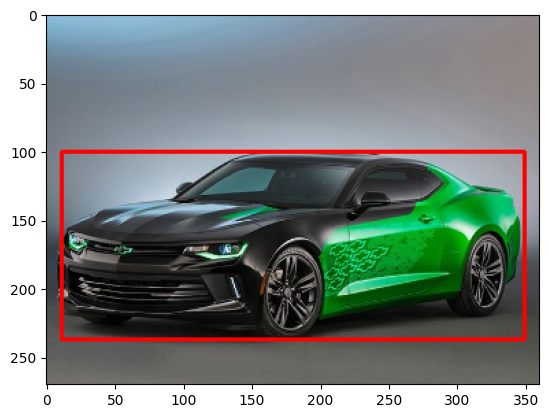

In [29]:
# Buat ngetest
features, bounded_img = preprocess_image(get_image("car", 4), 1000)
plt.imshow(bounded_img)

In [47]:


def load_dataset(dataset_paths):
    features = []
    labels = []
    
    for dataset_path in dataset_paths:
        if not os.path.isdir(dataset_path):
            print(f"Dataset path '{dataset_path}' does not exist or is not a directory.")
            continue
        
        for label in os.listdir(dataset_path):  # Loop through each folder (Ambulance, Car, Truck)
            label_path = os.path.join(dataset_path, label)
            if os.path.isdir(label_path):
                for image_file in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_file)
                    try:
                        # Load and preprocess the image
                        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
                        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize image
                        
                        # Extract features using preprocess_image
                        feature_vector = preprocess_image(image, target_feature_size=1000)
                        print(image_path)
                        print(features, labels)
                        features.append(feature_vector)
                        labels.append(label)  # Label is the folder name
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")
                        
                    break
            break
        break
    
    # Logging statistics
    print(f"Processed {len(features)} images in total.")
    for label in set(labels):
        print(f"Number of images for label '{label}': {labels.count(label)}")
    
    return np.array(features), np.array(labels)

# Assuming preprocess_image returns features and hog_image

## KNN

In [17]:
# KNN

def knn(dataset_path, img):
    try:
        features, labels = load_dataset(dataset_path)
        print(f"Features shape: {features.shape}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None
            
    # Feature scaling
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    print("Features scaled.")

    # Dimensionality reduction with PCA
    pca = PCA(n_components=0.95)  # Retain 95% variance
    features_reduced = pca.fit_transform(features_scaled)
    print("Features reduced to shape:", features_reduced.shape)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        features_reduced, labels, test_size=0.2, stratify=labels, random_state=42
    )
            
    print("Training set size:", X_train.shape[0])
    print("Test set size:", X_test.shape[0])

    # Hyperparameter tuning for KNN using GridSearchCV
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to test
        'weights': ['uniform', 'distance'],  # Weighting method for neighbors
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
    }

    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)
    
    # Start timing the grid search
    start_time = time.time()
    grid.fit(X_train, y_train)
    print(f"Best Parameters: {grid.best_params_}")
    knn = grid.best_estimator_
    print(f"GridSearchCV Time: {time.time() - start_time:.2f} seconds")

    # Evaluate the model
    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    print(confusion_matrix(y_test, y_pred))

    # Preprocess the new input image
    new_features = preprocess_image(img.convert('RGB'), features.shape[1])
    new_features = new_features.reshape(1, -1)  # Ensure it has the correct shape for prediction
    print("New features shape:", new_features.shape)
    
    # Scale and reduce the new features
    new_features = scaler.transform(new_features)
    print("New features shape SCALER:", new_features.shape)
    new_features = pca.transform(new_features)
    print("New features shape PCA:", new_features.shape)
            
    # Predict a new image
    prediction = knn.predict(new_features)
    proba = knn.predict_proba(new_features)
    # Show all results of the prediction
    print("All Predictions:", proba)
    print("Predicted Class:", prediction[0])
    
    return prediction, proba

## SVM

In [27]:
# SVM

def svm(dataset_path, img):
    try:
        features, labels = load_dataset(dataset_path)
        print(features, labels)
        print(f"Features shape: {features.shape}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None

    # # Feature scaling
    # scaler = StandardScaler()
    # features_scaled = scaler.fit_transform(features)

    # # Split dataset
    # X_train, X_test, y_train, y_test = train_test_split(
    #     features_scaled, labels, test_size=0.2, stratify=labels, random_state=42
    # )

    # # Hyperparameter tuning
    # param_grid = {
    #     'C': [0.01, 0.1, 1, 10, 100],
    #     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    #     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    #     'degree': [2, 3, 4]
    # }
    # grid = GridSearchCV(SVC(probability=True), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    # start_time = time.time()
    # grid.fit(X_train, y_train)
    # print(f"Best Parameters: {grid.best_params_}")
    # svm = grid.best_estimator_
    # print(f"Training Time: {time.time() - start_time:.2f} seconds")

    # # Evaluation
    # y_pred = svm.predict(X_test)
    # print(classification_report(y_test, y_pred, zero_division=0))
    # print(confusion_matrix(y_test, y_pred))

    # # Preprocess new image
    # new_features, original_bgr = preprocess_image(img.convert('RGB'), features.shape[1], test_image=True)
    # new_features = new_features.reshape(1, -1)
    # new_features = scaler.transform(new_features)

    # # Predict new image
    # proba = svm.predict_proba(new_features)
    # prediction = svm.predict(new_features)
    # print(f"Predicted Class: {prediction[0]}, Probabilities: {proba[0]}")

    # return prediction, proba, original_bgr

## Process

In [38]:
svm(dataset_path, img)

Error processing d:\Folder_Kuliah_Cadangan\Sems_7\Pengcit\VehicleRecognition\src\conventional\..\..\training_dataset\dataset (1)\bus\Image_1.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

Processed 0 images in total.
[] []
Features shape: (0,)
